In [340]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import statsmodels.api as sm

from scipy import interpolate
from adjustText import adjust_text # https://github.com/Phlya/adjustText

import ssl
ssl._create_default_https_context = ssl._create_unverified_context # dangerous but dirty hack to let me get csv from ourworldindata.org

## Growth factor of COVID-19.

Growth factor = new cases today / new cases yesterday

A growth factor constantly above 1 is a sign of exponential spread. Once the growth factor remains between 0 and 1, the spread is slowing down. 

Import time series data from [Our World in Data](https://ourworldindata.org/coronavirus-source-data):

In [2]:
url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
df_covid19 = pd.read_csv(url)
df_covid19

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0
3,2020-01-03,Afghanistan,0,0,0,0
4,2020-01-04,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
6819,2020-03-21,Zimbabwe,1,0,1,0
6820,2020-03-22,Zimbabwe,1,0,2,0
6821,2020-03-23,Zimbabwe,0,0,2,0
6822,2020-03-24,Zimbabwe,0,1,2,1


View the full list of countries that we have data for.

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_covid19['location'].value_counts())

Extract data for the United States:

In [303]:
df_usa = df_covid19[df_covid19['location'] == 'United States']
df_usa = df_usa.reset_index(drop=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_usa)

          date       location  new_cases  new_deaths  total_cases  \
0   2019-12-31  United States          0           0            0   
1   2020-01-01  United States          0           0            0   
2   2020-01-02  United States          0           0            0   
3   2020-01-03  United States          0           0            0   
4   2020-01-04  United States          0           0            0   
5   2020-01-05  United States          0           0            0   
6   2020-01-06  United States          0           0            0   
7   2020-01-07  United States          0           0            0   
8   2020-01-08  United States          0           0            0   
9   2020-01-09  United States          0           0            0   
10  2020-01-10  United States          0           0            0   
11  2020-01-11  United States          0           0            0   
12  2020-01-12  United States          0           0            0   
13  2020-01-13  United States     

Calculate growth factor:

In [305]:
def calculate_growth_factors(df):
    growth_factors = [0]
    yesterday = None

    for index, row in df.iterrows():
        today = row['new_cases']

        if yesterday is None:
            yesterday = today
            continue   
        elif yesterday == 0:
            growth_factor = today
        else:
            growth_factor = today/yesterday

        growth_factors.append(growth_factor)
        yesterday = today
        
    return growth_factors

In [308]:
df_usa['growth_factor'] = calculate_growth_factors(df_usa)
df_usa

,date,location,new_cases,new_deaths,total_cases,total_deaths,growth_factor
0,2019-12-31,United States,0,0,0,0,0.000000
1,2020-01-01,United States,0,0,0,0,0.000000
2,2020-01-02,United States,0,0,0,0,0.000000
3,2020-01-03,United States,0,0,0,0,0.000000
4,2020-01-04,United States,0,0,0,0,0.000000
...,...,...,...,...,...,...,...
81,2020-03-21,United States,5374,110,19624,260,1.111479
82,2020-03-22,United States,7123,80,26747,340,1.325456
83,2020-03-23,United States,8459,131,35206,471,1.187561
84,2020-03-24,United States,11236,119,46442,590,1.328289


Plot the cases and deaths:

In [ ]:
df_usa[['total_deaths', 'total_cases']][1:-1].plot.area(figsize=(20, 5))

In [ ]:
x = list(df_usa['date'][1:-1])
y = list(df_usa['total_cases'][1:-1])

plt.figure(figsize=(20,5))
plt.plot(x, y)
plt.xticks(np.arange(0, len(x), 10))
plt.show()

Format dates

In [324]:
def format_x(df, start):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
    x = [] # dates
    for i in list(df['date'][start:-1].str.split('-')):
        date = months[int(i[1]) - 1] + ' ' + str(int(i[2]))
        x.append(date)
    return x

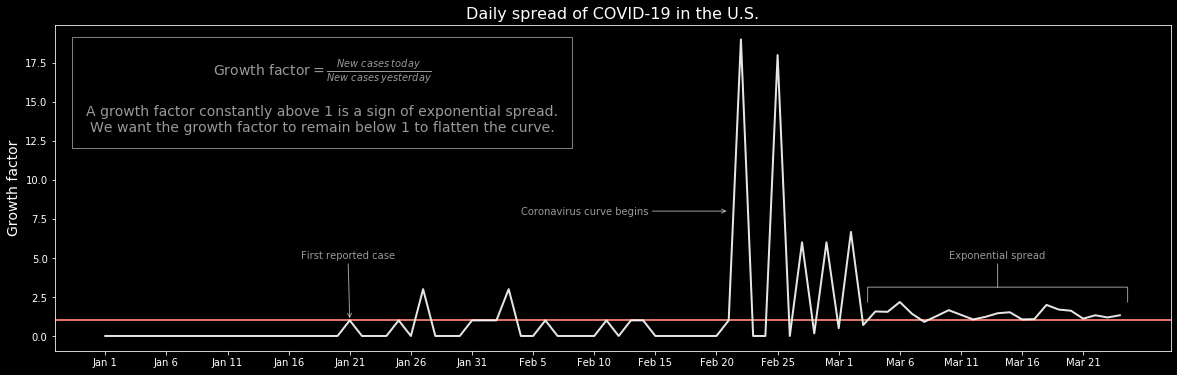

In [357]:
x = format_x(df_usa, 1)
x_range = np.arange(0, len(x))
y = list(df_usa['growth_factor'][1:-1])

plt.figure(figsize=(20,6))

# Add horizontal line
plt.axhline(y=1, color='#fa8174', alpha=0.9, linestyle='-', lw=2)

plt.plot(x, y, color="white", alpha=0.9, lw=2)
#plt.yticks(np.arange(0, len(y), 100))
plt.xticks(np.arange(0, len(x), 5))
plt.ylabel('Growth factor', fontsize=14)
plt.title('Daily spread of COVID-19 in the U.S.', fontsize=16)

# Generate non-overlapping data point labels
#texts = [plt.text(x_range[i], y[i], round(y[i], 2)) if y[i] > 0 and y[i] != 1 else plt.text(x_range[i], y[i], '') for i in range(len(x))]
#f = interpolate.interp1d(x_range, y)
#f_x = np.arange(min(x_range), max(x_range), 0.005)
#f_y = f(f_x)
#adjust_text(texts, x=f_x, y=f_y,
#            only_move={'points': 'y', 'text': 'y'},
#            force_points=0.5,
#            autoalign='y',
#            arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))



# Annotate
plt.annotate('Coronavirus curve begins', (51, 8), 
             xytext=(34, 8),
             va='center', alpha=0.6,
             arrowprops=dict(arrowstyle="->", lw=1, alpha=0.6))

plt.annotate('First reported case', (20, 1), 
             xytext=(16, 5), alpha=0.6,
             arrowprops=dict(arrowstyle="->", lw=1, alpha=0.6))

plt.annotate('Exponential spread', (73, 3), 
             xytext=(73, 5), ha='center', alpha=0.6,
             arrowprops=dict(arrowstyle="-[, widthB=13.0, lengthB=1.5", lw=1, alpha=0.6))

# Add text explanation
formula = r"Growth factor$= \frac{New\;cases\;today}{New\;cases\;yesterday}$"
info_str = "\n\nA growth factor constantly above 1 is a sign of exponential spread.\nWe want the growth factor to remain below 1 to flatten the curve."
ax = plt.gca()
ax.text(0.24, 0.9, formula + info_str, transform=ax.transAxes, fontsize=14, 
        verticalalignment='top', alpha=0.6, ha='center',
        bbox=dict(boxstyle='square, pad=1', facecolor='black', alpha=0.5))

#plt.show()
plt.savefig('growth_factor2.png')

In [348]:
plt.rcParams['axes.prop_cycle']

'#8dd3c7'
'#feffb3'
'#bfbbd9'
'#fa8174'
'#81b1d2'
'#fdb462'
'#b3de69'
'#bc82bd'
'#ccebc4'
'#ffed6f'


#### China

In [323]:
df_china = df_covid19[df_covid19['location'] == 'China']
df_china = df_china.reset_index(drop=True)
df_china['growth_factor'] = calculate_growth_factors(df_china)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_china)

          date location  new_cases  new_deaths  total_cases  total_deaths  \
0   2019-12-31    China         27           0           27             0   
1   2020-01-01    China          0           0           27             0   
2   2020-01-02    China          0           0           27             0   
3   2020-01-03    China         17           0           44             0   
4   2020-01-04    China          0           0           44             0   
5   2020-01-05    China         15           0           59             0   
6   2020-01-06    China          0           0           59             0   
7   2020-01-07    China          0           0           59             0   
8   2020-01-08    China          0           0           59             0   
9   2020-01-09    China          0           0           59             0   
10  2020-01-10    China          0           0           59             0   
11  2020-01-11    China          0           1           59             1   

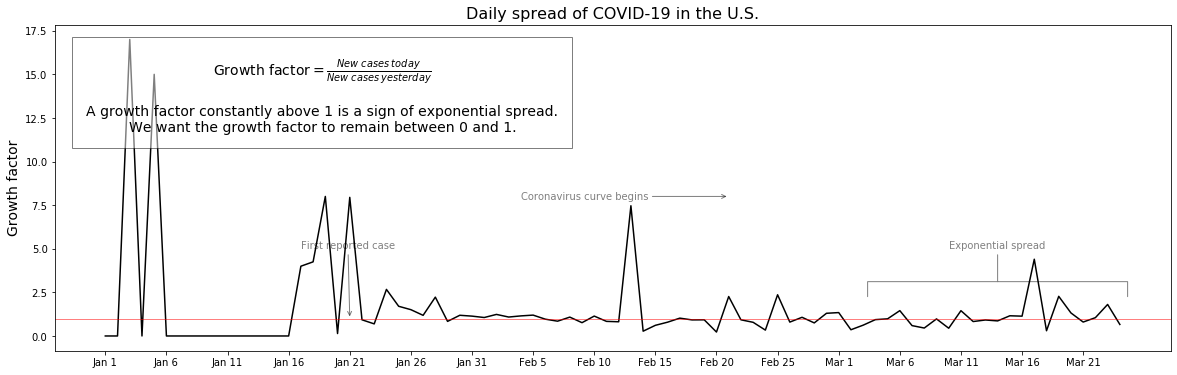

In [325]:
x = format_x(df_china, 1)
x_range = np.arange(0, len(x))
y = list(df_china['growth_factor'][1:-1])

plt.figure(figsize=(20,6))
plt.plot(x, y, color="black", alpha=1)
#plt.yticks(np.arange(0, len(y), 100))
plt.xticks(np.arange(0, len(x), 5))
plt.ylabel('Growth factor', fontsize=14)
plt.title('Daily spread of COVID-19 in the U.S.', fontsize=16)

# Add horizontal line
plt.axhline(y=1, color='red', linestyle='-', lw=0.5)

# Annotate
plt.annotate('Coronavirus curve begins', (51, 8), 
             xytext=(34, 8),
             va='center', alpha=0.5,
             arrowprops=dict(arrowstyle="->", lw=1, alpha=0.5))

plt.annotate('First reported case', (20, 1), 
             xytext=(16, 5), alpha=0.5,
             arrowprops=dict(arrowstyle="->", lw=1, alpha=0.5))

plt.annotate('Exponential spread', (73, 3), 
             xytext=(73, 5), ha='center', alpha=0.5,
             arrowprops=dict(arrowstyle="-[, widthB=13.0, lengthB=1.5", lw=1, alpha=0.5))

# Add text explanation
formula = r"Growth factor$= \frac{New\;cases\;today}{New\;cases\;yesterday}$"
info_str = "\n\nA growth factor constantly above 1 is a sign of exponential spread.\nWe want the growth factor to remain between 0 and 1."
ax = plt.gca()
ax.text(0.24, 0.9, formula + info_str, transform=ax.transAxes, fontsize=14, 
        verticalalignment='top', alpha=1, ha='center',
        bbox=dict(boxstyle='square, pad=1', facecolor='white', alpha=0.5))

#plt.show()
plt.savefig('growth_factor2.png')

Extract data for Italy:

In [311]:
df_italy = df_covid19[df_covid19['location'] == 'Italy']
df_italy = df_italy.reset_index(drop=True)
df_italy['growth_factor'] = calculate_growth_factors(df_italy)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_italy)

          date location  new_cases  new_deaths  total_cases  total_deaths  \
0   2019-12-31    Italy          0           0            0             0   
1   2020-01-01    Italy          0           0            0             0   
2   2020-01-02    Italy          0           0            0             0   
3   2020-01-03    Italy          0           0            0             0   
4   2020-01-04    Italy          0           0            0             0   
5   2020-01-05    Italy          0           0            0             0   
6   2020-01-06    Italy          0           0            0             0   
7   2020-01-07    Italy          0           0            0             0   
8   2020-01-08    Italy          0           0            0             0   
9   2020-01-09    Italy          0           0            0             0   
10  2020-01-10    Italy          0           0            0             0   
11  2020-01-11    Italy          0           0            0             0   

Plot Italy:

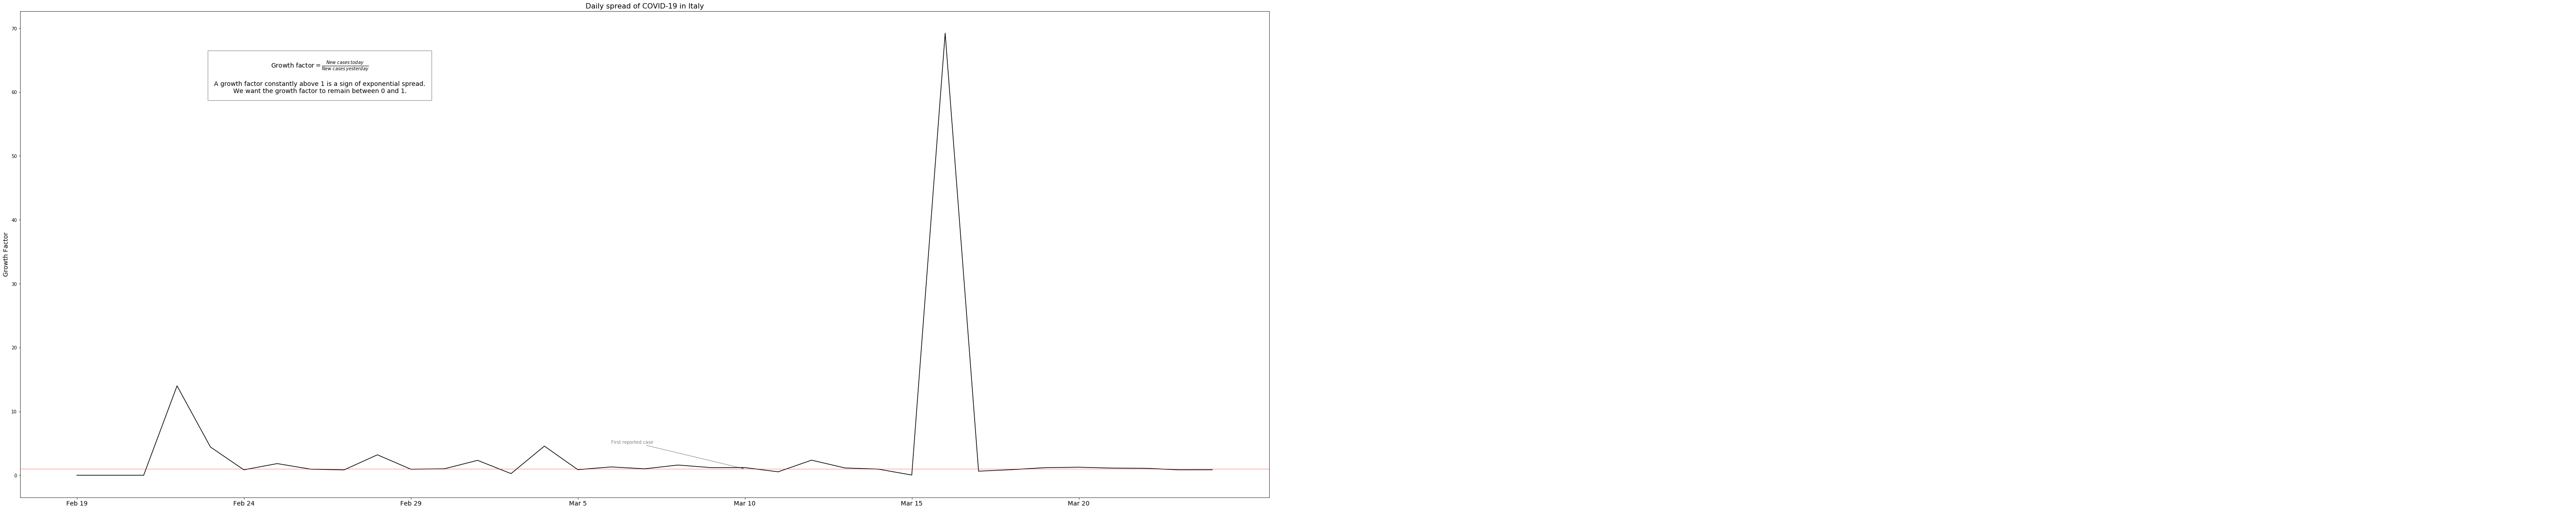

In [337]:
x = format_x(df_italy, 50)
x_range = np.arange(0, len(x))
y = list(df_italy['growth_factor'][50:-1])

plt.figure(figsize=(50,20))
plt.plot(x, y, color="black", alpha=1)
#plt.yticks(np.arange(0, len(y), 100))
plt.xticks(np.arange(0, len(x), 5), fontsize=14)
plt.ylabel('Growth Factor', fontsize=14)
plt.title('Daily spread of COVID-19 in Italy', fontsize=16)

# Add horizontal line
plt.axhline(y=1, color='red', linestyle='-', lw=0.5)

# Annotate
plt.annotate('Coronavirus curve begins', (51, 8), 
             xytext=(34, 8),
             va='center', alpha=0.5,
             arrowprops=dict(arrowstyle="->", lw=1, alpha=0.5))

plt.annotate('First reported case', (20, 1), 
             xytext=(16, 5), alpha=0.5,
             arrowprops=dict(arrowstyle="->", lw=1, alpha=0.5))

plt.annotate('Exponential spread', (73, 3), 
             xytext=(73, 5), ha='center', alpha=0.5,
             arrowprops=dict(arrowstyle="-[, widthB=13.0, lengthB=1.5", lw=1, alpha=0.5))

# Add text explanation
formula = r"Growth factor$= \frac{New\;cases\;today}{New\;cases\;yesterday}$"
info_str = "\n\nA growth factor constantly above 1 is a sign of exponential spread.\nWe want the growth factor to remain between 0 and 1."
ax = plt.gca()
ax.text(0.24, 0.9, formula + info_str, transform=ax.transAxes, fontsize=14, 
        verticalalignment='top', alpha=1, ha='center',
        bbox=dict(boxstyle='square, pad=1', facecolor='white', alpha=0.5))

plt.show()
#plt.savefig('growth_factor2.png')

### Logarithms of infections:

Get rid of rows with 0 cases.

In [ ]:
df_usa = df_usa[df_usa['total_cases'] != 0]

Calculate logarithm of infections:

In [ ]:
df_usa['log_infections'] = np.log(df_usa['total_cases'])
df_usa

Run linear regression:

In [ ]:
x = sm.add_constant(df_usa.index)
y = df_usa['log_infections']
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

Remember the linear regression function?

y = a + b * x

The table gives the values for a and b under coef. 

- The value const is the value for a: -3.6277
- The value x1 is the value for b: 0.1500

Remember that we said that the a is the log of the initial value. This is -3.6277. 

We also said that the b is the log of the growth factor. This is 0.1500. 

So if we "unlog" them by applying the exponential, we find these actual values.

In [ ]:
initial_value = np.exp(-3.6277)
initial_value

In [ ]:
growth_factor = np.exp(0.1500)
growth_factor

Going back to the original formula for exponential growth, we fill in those values to find the actual formula for the coronvirus pandemic:

x(t) = x0 * b^t

x(t) = 0.0266 * 1.1618^t

In [ ]:
def linear_predictions(t):
    return initial_value * growth_factor ** t

In [ ]:
df_usa['predictions'] = df_usa.index.to_series().apply(linear_predictions)

In [ ]:
df_usa

In [ ]:
plt.plot(df_usa.index, df_usa['total_cases'], 'red')
plt.plot(df_usa.index, df_usa['predictions'], 'blue')
plt.title('Predicted number of cases vs real number of cases')
plt.xlabel('Time')
plt.ylabel('Infections')
plt.legend()